Curso de
- Classificação: otimizando modelos de machine learning
- Classificação: selecionando features

# Bibliotecas e DataFrame

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline

#ignorando Warning inuteis
import warnings 
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
# Carregar os dados
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df = pd.read_csv(url)

# Identificar colunas a serem removidas # Remover colunas inúteis
columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
df = df.drop(columns=columns_to_drop)
df = df.dropna()

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [4]:
colunas_cat = ['Pclass','Sex','Embarked']
for coluna in colunas_cat:
    df[coluna] = df[coluna].astype('O')

colunas_binarias = []
for coluna in df.columns:
    if df[coluna].dtype == 'O':
        categorias = df[coluna].unique()
        if len(categorias) == 2:
            print('2 niveis:', coluna, '=>', categorias)
            colunas_binarias.append(coluna)
        else:
            print('3 niveis:', coluna, '=>', categorias)
            colunas_binarias.append(coluna)

3 niveis: Pclass => [3 1 2]
2 niveis: Sex => ['male' 'female']
3 niveis: Embarked => ['S' 'C' 'Q']


In [5]:
x = df.drop('Survived', axis=1)
y = df['Survived']

x_inteiro = x
y_inteiro = y

#colunas_binarias.remove('Survived')

## Dummyrisação

In [6]:
# DUMMYRISAÇÃO
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder #transformando colunas com 2 categorias em 0 e 1

coluna = x.columns
one_hot = make_column_transformer((
    OneHotEncoder(drop='if_binary'), #caso a coluna tenha apenas 2 categorias 
    colunas_binarias), #passando quais são essas colunas
    remainder = 'passthrough', sparse_threshold=0) #oque deve ser feito com as outras

#Aplicando transformação
x = one_hot.fit_transform(x)

#Os novos nomes das colunas #'onehotencoder=transformadas; 'remainder'=não transformadas
novos_nomes_colunas = one_hot.get_feature_names_out(coluna)

########################################################################################
# PADRONIZAÇÃO DOS DADOS
from sklearn.preprocessing import MinMaxScaler

normalizacao = MinMaxScaler()
#x = normalizacao.fit_transform(x)

x = pd.DataFrame(x, columns = novos_nomes_colunas) #alterando de volta
x_columns = x.columns.tolist() 
x.head()

,onehotencoder__Pclass_1,onehotencoder__Pclass_2,onehotencoder__Pclass_3,onehotencoder__Sex_male,onehotencoder__Embarked_C,onehotencoder__Embarked_Q,onehotencoder__Embarked_S,remainder__Age,remainder__SibSp,remainder__Parch,remainder__Fare
0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,22.0,1.0,0.0,7.2500
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,38.0,1.0,0.0,71.2833
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,26.0,0.0,0.0,7.9250
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,35.0,1.0,0.0,53.1000
4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,35.0,0.0,0.0,8.0500


In [7]:
RANDOM_STATE = 42

# SEPARANDO DADOS PARA TREINO E TESTE
from sklearn.model_selection import train_test_split
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, 
                                          stratify = y, #para manter a proporção da Var Dep nos splits
                                          random_state = RANDOM_STATE, #raiz da aleatoridade
                                          test_size = 0.33) #porcentagem que ira ser separado para testes

x_treino.shape, x_teste.shape, y_treino.shape, y_teste.shape

((477, 11), (235, 11), (477,), (235,))

# Funções para avaliação

In [8]:
# CODIGOS PARA VALIDAÇÃO
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, RocCurveDisplay

def avaliar_modelo(y_verdadeiro, y_predito, conjunto_nome):
    """
    Função para avaliar e imprimir o relatório de classificação e a matriz de confusão.
    """
    #if conjunto_nome == "Treino":
     #   pass
    #else:
    print('*' * 70)
    print("Relatório de Classificação para o Conjunto de", conjunto_nome,":\n")
    print(classification_report(y_verdadeiro, y_predito))
    
    print('*' * 55)
    
    print("Matriz de Confusão para o Conjunto de", conjunto_nome,":\n")
    print(confusion_matrix(y_verdadeiro, y_predito))
    print('*' * 70)

    display(RocCurveDisplay.from_predictions(y_verdadeiro, y_predito, name = conjunto_nome))

In [9]:
def intervalo_conf(resultados):
    media = resultados.mean()
    desvio_padrao = resultados.std()
    ic_0 = round(media - 2*desvio_padrao, 2)
    ic_1 = round(min(media + 2*desvio_padrao, 1), 2)
    ic = '[' + str(ic_0) + ' - ' + str(ic_1) + ']'
    return ic

def histograma(dados):
    dados = dados
    plt.figure(figsize=(15,5))
    plt.hist(dados, edgecolor='black', density=True) #bins=q_bins, 

    plt.title('hist', fontsize=15)
    plt.grid(True, color='gray')

    # Adicionar linhas verticais para média e mediana
    plt.axvline(x = dados.mean(), color='red', linestyle='--', label='Média')
    plt.axvline(x = dados.median(), color='blue', linestyle='--', label='Mediana')

    # Adicionar legenda personalizada
    texto_count = 'Count = ' + str(round(len(dados), 0))
    texto_media = 'Média = '+ str(round(dados.mean(), 2))
    texto_dp = 'DP = '+ str(round(dados.std(), 2))
    texto_min = 'Min = '+ str(round(dados.min(), 2))
    texto_Q1 = 'Q1 = ' + str(round(dados.quantile(0.25), 2))
    texto_mediana = 'Q2 = '+ str(round(dados.median(), 2))
    texto_Q3 = 'Q3 = ' + str(round(dados.quantile(0.75), 2))
    texto_max = 'Max = '+ str(round(dados.max(), 2))
    ic = 'IC ' + intervalo_conf(dados)
    texto_legenda = '\n'.join([texto_count, 
                               texto_min,
                               texto_media, texto_dp, 
                               texto_Q1, texto_mediana, texto_Q3,
                               texto_max, 
                               ic])

    plt.text(0.99, 0.96, texto_legenda, ha='right', va='top', transform=plt.gca().transAxes,
             bbox=dict(facecolor='black', edgecolor='gray', boxstyle='round'),
             fontsize=12)

    plt.show()

# Modelos de Machine Learning

## Decision Tree Simples

In [10]:
from sklearn.tree import DecisionTreeClassifier

modelo_dt = DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE)
modelo_dt.fit(x_treino, y_treino)

DecisionTreeClassifier(max_depth=3, random_state=42)

**********************************************************************
Relatório de Classificação para o Conjunto de Treino :

              precision    recall  f1-score   support

           0       0.89      0.79      0.84       284
           1       0.73      0.86      0.79       193

    accuracy                           0.82       477
   macro avg       0.81      0.82      0.81       477
weighted avg       0.83      0.82      0.82       477

*******************************************************
Matriz de Confusão para o Conjunto de Treino :

[[224  60]
 [ 27 166]]
**********************************************************************


**********************************************************************
Relatório de Classificação para o Conjunto de Teste :

              precision    recall  f1-score   support

           0       0.85      0.74      0.79       140
           1       0.68      0.80      0.73        95

    accuracy                           0.77       235
   macro avg       0.76      0.77      0.76       235
weighted avg       0.78      0.77      0.77       235

*******************************************************
Matriz de Confusão para o Conjunto de Teste :

[[104  36]
 [ 19  76]]
**********************************************************************


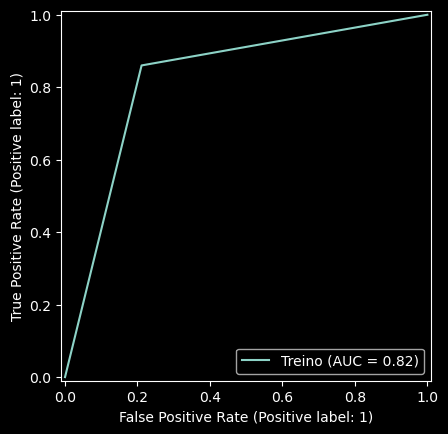

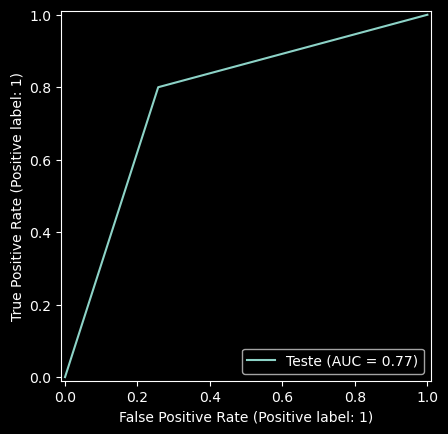

In [11]:
#######################################################################################

# Avaliação no conjunto de treino # Verificando Over/Under(Fitting)
previsoes_treino = modelo_dt.predict(x_treino)
avaliar_modelo(y_treino, previsoes_treino, "Treino")

# Avaliação no conjunto de teste  # Relatório de classificação
previsoes = modelo_dt.predict(x_teste)
avaliar_modelo(y_teste, previsoes, "Teste")
#######################################################################################

## Logistic Regression

**********************************************************************
Relatório de Classificação para o Conjunto de Treino :

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       284
           1       0.78      0.72      0.75       193

    accuracy                           0.81       477
   macro avg       0.80      0.79      0.79       477
weighted avg       0.80      0.81      0.80       477

*******************************************************
Matriz de Confusão para o Conjunto de Treino :

[[246  38]
 [ 55 138]]
**********************************************************************


**********************************************************************
Relatório de Classificação para o Conjunto de Teste :

              precision    recall  f1-score   support

           0       0.82      0.83      0.82       140
           1       0.74      0.73      0.73        95

    accuracy                           0.79       235
   macro avg       0.78      0.78      0.78       235
weighted avg       0.79      0.79      0.79       235

*******************************************************
Matriz de Confusão para o Conjunto de Teste :

[[116  24]
 [ 26  69]]
**********************************************************************


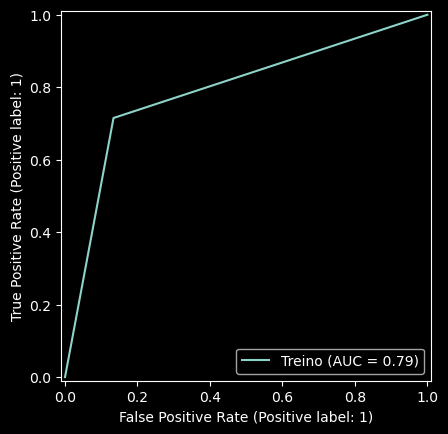

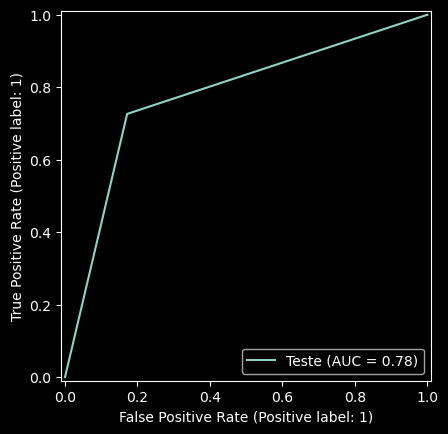

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
classificador = make_pipeline(StandardScaler(), LogisticRegression(random_state=RANDOM_STATE))

#######################################################################################
# Treinamento do Modelo
classificador.fit(x_treino, y_treino)

# Avaliação no conjunto de treino # Verificando Over/Under(Fitting)
previsoes_treino = classificador.predict(x_treino)
avaliar_modelo(y_treino, previsoes_treino, "Treino")

# Avaliação no conjunto de teste  # Relatório de classificação
previsoes = classificador.predict(x_teste)
avaliar_modelo(y_teste, previsoes, "Teste")
#######################################################################################

# Busca em Grade

## Decision Tree Classifier

In [13]:
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, 
                     shuffle=True, # embarelhamento dos dados
                     random_state=RANDOM_STATE)


param_grid_dt = {
    'criterion': ['gini', 'entropy'], # a função que vai decidir a qualidade de uma divisão
    'max_depth': np.linspace(6, 12, 4, dtype=int), # profundidade da arvore
    'min_samples_split': np.linspace(5, 20, 4, dtype=int), # quantidade minima de amostra para dividir um nó interno
    'min_samples_leaf': np.linspace(5, 20, 4, dtype=int), # quantidade minima de amostra para estar em uma folha
    'max_features': ['sqrt', 'log2'], # quantidade máxima de features que devem estar na divisão de um nó
    'splitter': ['best', 'random'] # mede se a forma de divisão é a melhor ou aleatória.
}

dt_grid_search = GridSearchCV(estimator = DecisionTreeClassifier(random_state=RANDOM_STATE), #classificador - modelo
             param_grid = param_grid_dt,  
             scoring='recall', # metrica que sera avaliada
             n_jobs=-1, # quantidade de processadores para usar da maquina #-1 usa todos os disponiveis
             refit=True, # retreinar com os melhores hiper parametros
             cv=cv, # validação cruzada
             verbose=0, # mede a quantidade de informações que sera retornada # 0 é o padrão
             pre_dispatch='2*n_jobs', #
             #error_score=nan, #
             return_train_score=False) # scores de treinamento

dt_grid_search.fit(x_treino, y_treino)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 6,  8, 10, 12]),
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': array([ 5, 10, 15, 20]),
                         'min_samples_split': array([ 5, 10, 15, 20]),
                         'splitter': ['best', 'random']},
             scoring='recall')

In [14]:
# melhores hiper-parametros
dt_grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'splitter': 'best'}

In [15]:
df_cv_results_dt = pd.DataFrame(dt_grid_search.cv_results_)
print(df_cv_results_dt.shape)
df_cv_results_dt.head().T

(512, 19)


,0,1,2,3,4
mean_fit_time,0.007004,0.005796,0.004347,0.006056,0.003131
std_fit_time,0.003009,0.005392,0.005,0.004945,0.002744
mean_score_time,0.003867,0.003323,0.001003,0.005249,0.004532
std_score_time,0.003815,0.002837,0.002006,0.002693,0.003101
param_criterion,gini,gini,gini,gini,gini
param_max_depth,6,6,6,6,6
param_max_features,sqrt,sqrt,sqrt,sqrt,sqrt
param_min_samples_leaf,5,5,5,5,5
param_min_samples_split,5,5,10,10,15
param_splitter,best,random,best,random,best


In [16]:
df_cv_results_dt.loc[[dt_grid_search.best_index_]].T

,128
mean_fit_time,0.005094
std_fit_time,0.003201
mean_score_time,0.003052
std_score_time,0.003905
param_criterion,gini
param_max_depth,10
param_max_features,sqrt
param_min_samples_leaf,5
param_min_samples_split,5
param_splitter,best


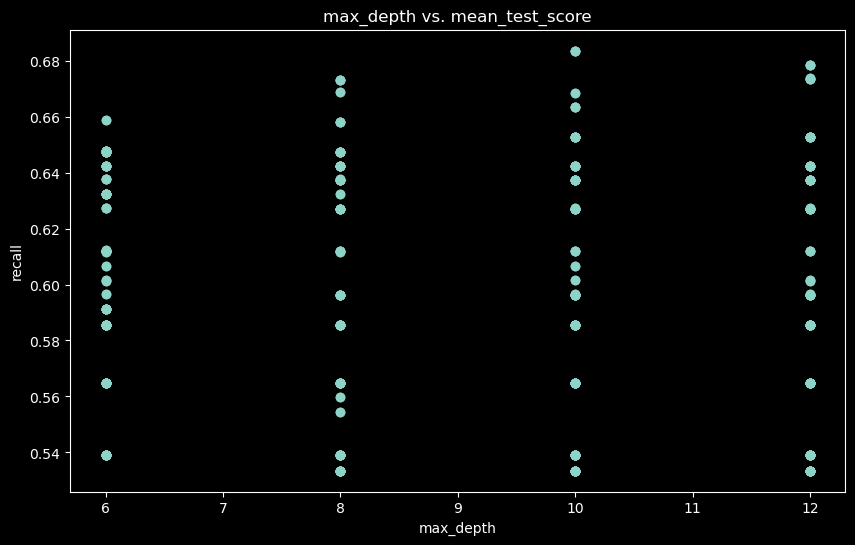

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(
    df_cv_results_dt['param_max_depth'],
    df_cv_results_dt['mean_test_score'],
    )

plt.title('max_depth vs. mean_test_score')
plt.xlabel('max_depth')
plt.ylabel('recall')
plt.show()

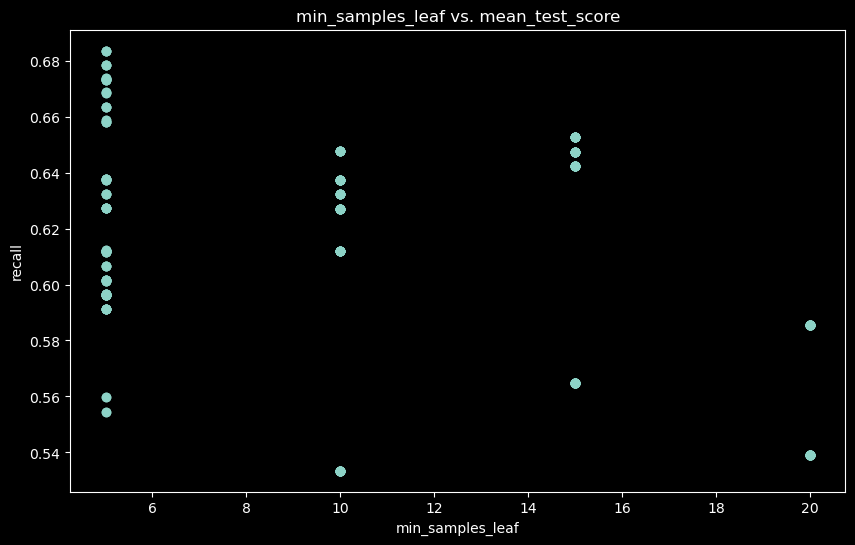

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(
    df_cv_results_dt['param_min_samples_leaf'],
    df_cv_results_dt['mean_test_score'],
    )

plt.title('min_samples_leaf vs. mean_test_score')
plt.xlabel('min_samples_leaf')
plt.ylabel('recall')
plt.show()

## Logistic Regression

In [19]:
max_iter = np.linspace(100, 300, 5, dtype=int)
c = [0.001, 0.01, 0.1, 1, 10]

param_grid_lr = [ # Há duas grades
    {'logisticregression__solver' : ['newton-cg', 'lbfgs'],
      'logisticregression__penalty' : ['l2'],
      'logisticregression__max_iter' : max_iter,
       'logisticregression__C' : c},
    {'logisticregression__solver' : ['liblinear'],
      'logisticregression__penalty' : ['l1', 'l2'],
      'logisticregression__max_iter' : max_iter,
      'logisticregression__C' : c},
]

from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, 
                     shuffle=True, # embarelhamento dos dados
                     random_state=RANDOM_STATE)

lr_grid_search = GridSearchCV(estimator = make_pipeline(StandardScaler(), LogisticRegression()),
                              param_grid = param_grid_lr,
                              scoring = "recall",
                              n_jobs = -1,
                              cv = cv)

lr_grid_search.fit(x_treino, y_treino)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'logisticregression__C': [0.001, 0.01, 0.1, 1, 10],
                          'logisticregression__max_iter': array([100, 150, 200, 250, 300]),
                          'logisticregression__penalty': ['l2'],
                          'logisticregression__solver': ['newton-cg', 'lbfgs']},
                         {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10],
                          'logisticregression__max_iter': array([100, 150, 200, 250, 300]),
                          'logisticregression__penalty': ['l1', 'l2'],
                          'logisticregression__solver': ['liblinear']}],
             scoring='recall')

In [20]:
lr_grid_search.best_params_

{'logisticregression__C': 1,
 'logisticregression__max_iter': 100,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'newton-cg'}

In [21]:
df_cv_results_lr = pd.DataFrame(lr_grid_search.cv_results_)
df_cv_results_lr.head().T

,0,1,2,3,4
mean_fit_time,0.023267,0.014515,0.007081,0.007188,0.006053
std_fit_time,0.005699,0.006318,0.002426,0.003564,0.003252
mean_score_time,0.004392,0.005455,0.005778,0.00555,0.006269
std_score_time,0.0039,0.002175,0.002202,0.001767,0.003296
param_logisticregression__C,0.001,0.001,0.001,0.001,0.001
param_logisticregression__max_iter,100,100,150,150,200
param_logisticregression__penalty,l2,l2,l2,l2,l2
param_logisticregression__solver,newton-cg,lbfgs,newton-cg,lbfgs,newton-cg
params,"{'logisticregression__C': 0.001, 'logisticregr...","{'logisticregression__C': 0.001, 'logisticregr...","{'logisticregression__C': 0.001, 'logisticregr...","{'logisticregression__C': 0.001, 'logisticregr...","{'logisticregression__C': 0.001, 'logisticregr..."
split0_test_score,0.076923,0.076923,0.076923,0.076923,0.076923


In [22]:
df_cv_results_lr.loc[[lr_grid_search.best_index_]].T

,30
mean_fit_time,0.004932
std_fit_time,0.004063
mean_score_time,0.011696
std_score_time,0.010572
param_logisticregression__C,1
param_logisticregression__max_iter,100
param_logisticregression__penalty,l2
param_logisticregression__solver,newton-cg
params,"{'logisticregression__C': 1, 'logisticregressi..."
split0_test_score,0.641026


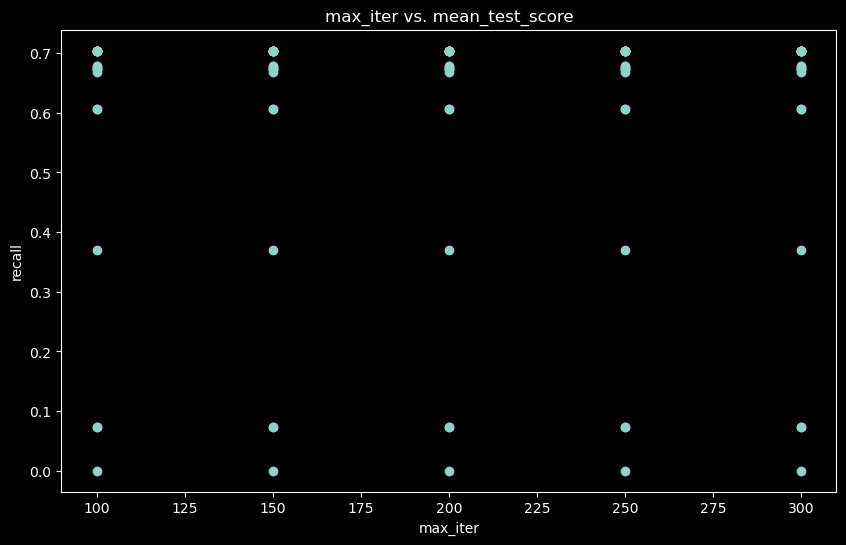

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(
    df_cv_results_lr['param_logisticregression__max_iter'],
    df_cv_results_lr['mean_test_score'],
    )

plt.title('max_iter vs. mean_test_score')
plt.xlabel('max_iter')
plt.ylabel('recall')
plt.show()

# Validação cruzada aninhada
se utilizarmos a validação cruzada normal, a qual utilizamos nas células anteriores, ela produz um resultado que é mais otimista do que deveria ser. Para resolver isso, utilizamos uma técnica para obter um erro de generalização mais adequado: a validação cruzada aninhada (Nested Cross Validation).
- ler sobre "Validação cruzada aninhada versus não aninhada"

## Decision Tree Classifier

In [24]:
# Validação internar
inner_cv = StratifiedKFold(shuffle=True, random_state=RANDOM_STATE)

# Validação externar
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

In [25]:
from sklearn.model_selection import cross_val_score

dt_nested_gs = GridSearchCV(estimator = DecisionTreeClassifier(random_state=RANDOM_STATE),
                                         param_grid = param_grid_dt,
                                         scoring = "recall",
                                         n_jobs = -1,
                                         cv = inner_cv
                                         )

dt_nested_scores = cross_val_score(dt_nested_gs, x_treino, y_treino, cv=outer_cv)

print(f'resultado de cada iteração do cv externo: {dt_nested_scores}')
print(f'média: {dt_nested_scores.mean()}')

resultado de cada iteração do cv externo: [0.546875   0.578125   0.76923077]
média: 0.6314102564102564


# Otimização Bayesiana

## LazyClassifier

LazyPedict é uma biblioteca que ajuda a semi-automatizar os modelos de Machine Learning.

Essa biblioteca constrói muitos modelos básicos sem muito código e ajuda a entender quais modelos funcionam melhor sem qualquer ajuste de parâmetro.

Após a obtenção dos resultados de acurácia e avaliação das métricas podemos escolher os melhores modelos e aplicar o ajuste de hiperparâmetros a eles.

Então, no caso dos dados deste projeto vou usar o LazyClassifier para tentar resolver o problema de classificação:

In [ ]:
from lazypredict.Supervised import LazyClassifier, LazyRegressor

np.random.seed(73246) #para garantir a reprodutibilidade

#x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=0)

# fit all models
clf = LazyClassifier(predictions=True)
models, predictions = clf.fit(x, x_teste, y, y_teste) 
'''"clf" está retornando dois valores, Modelo e Previsão, enquanto modelo significa 
todos os modelos e com algumas métricas e previsão significa todo o valor previsto que é ŷ'''
models